$$
  -\Delta u(x,y) \;=\; f(x,y),
  \qquad (x,y)\in[a,a+L_x]\times[b,b+L_y],
$$
$$
a=0,\quad b=1/2,\quad Lx=2,\quad Ly=5/2
$$
$$
  f(x,y) = 2\pi^2\,\sin(\pi x)\cos(\pi y).
$$
$$
  u(a,y) = u(a+L_x,y) = u(x,b+L_y) = 0,
$$
$$
  \frac{\partial u}{\partial n}(x,y) = -\frac{\partial u}{\partial y}(x,b) = 0,
$$

In [1]:
# =============
# CARGA DE LIBRERIAS

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

c:\Users\alfa\anaconda3\envs\TFGM\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


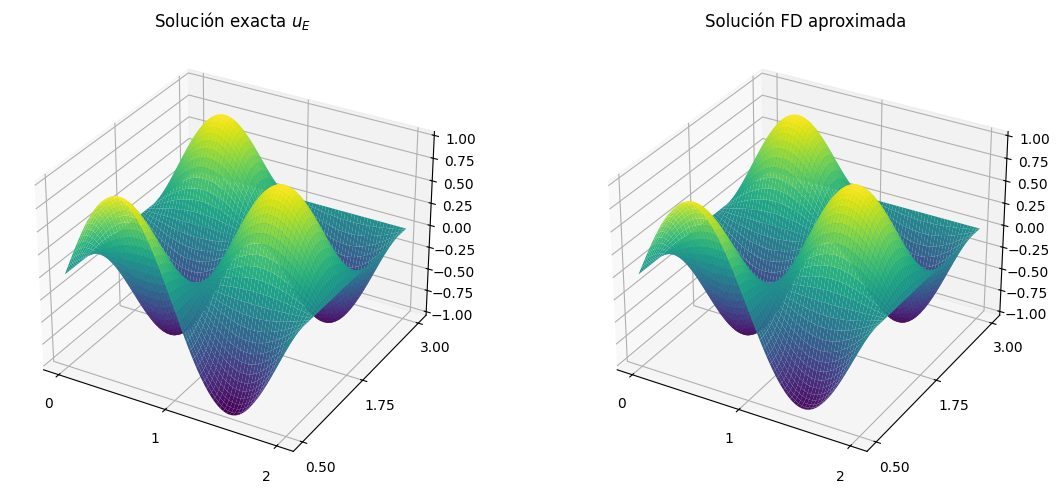

In [2]:
# Parámetros del dominio y malla
a, b = 0, 1/2               # origen
Lx, Ly = 2, 5/2             # dimensiones en x e y
N = 199                     # N+1 subdivisiones ⇒ N+2 nodos
hx = Lx / (N + 1)           # paso en x
hy = Ly / (N + 1)           # paso en y
x = np.linspace(a, a + Lx, N + 2)
y = np.linspace(b, b + Ly, N + 2)
X, Y = np.meshgrid(x, y, indexing='ij')

# Solución exacta y fuente/Neumann
def uE(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

def f_source(x, y):
    return 2 * (np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

def qS(x):
    return 0

# Índices de frontera (ravel)
xx = X.ravel()
yy = Y.ravel()
nfO = np.where(np.isclose(xx, a))[0]        # oeste: Dirichlet
nfE = np.where(np.isclose(xx, a + Lx))[0]   # este: Dirichlet
nfN = np.where(np.isclose(yy, b + Ly))[0]   # norte: Dirichlet
nfD = np.union1d(np.union1d(nfO, nfE), nfN) # conjunto Dirichlet
nfS = np.where(np.isclose(yy, b))[0]        # sur: Neumann

# Operador 1D en x (segundo orden)
I_x = sparse.eye(N + 2)
e = np.ones(N + 1)
E_x = sparse.diags(e, -1)
D_x = (2 * I_x - E_x - E_x.T).tocsr()

# Operador 1D en y con Neumann de primer orden en j=0
I_y = sparse.eye(N + 2)
E_y = sparse.diags(e, -1)
# Construimos inicialmente el Laplaciano 3‑puntos
D_y = (2 * I_y - E_y - E_y.T).tolil()
# Para j=0 (y=b) sustituimos por forward‑difference de primer orden:
# ∂u/∂y ≈ (u₁ - u₀)/hy = qS  ⇒  fila: (-u₀ + u₁)/hy
# No necesitamos ajustar RHS, pues el PDE usa este operador directo.
D_y[0, :] = 0
D_y[0, 0] = -1
D_y[0, 1] =  1
D_y = D_y.tocsr()

# Montaje de la Laplaciana 2D
A = (sparse.kron(D_x, I_y) / hx**2
   + sparse.kron(I_x, D_y) / hy**2)

# Vector RHS evaluado en la malla interna
fV = f_source(X, Y).ravel()

# Imposición de Dirichlet fuerte por penalización
penalty = 1e16
for idx in nfD:
    A[idx, :] = 0
    A[idx, idx] = penalty
    fV[idx] = penalty * uE(xx[idx], yy[idx])

# Resolución del sistema
sol = spsolve(A.tocsc(), fV)
uA = sol.reshape((N + 2, N + 2))

# Visualización comparativa
xticks = [a, a + Lx/2, a + Lx]
yticks = [b, b + Ly/2, b + Ly]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, uE(X, Y), cmap='viridis', rstride=3, cstride=3)
ax1.set_title('Solución exacta $u_E$')
ax1.set_xticks(xticks); ax1.set_yticks(yticks)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, uA, cmap='viridis', rstride=3, cstride=3)
ax2.set_title('Solución FD aproximada')
ax2.set_xticks(xticks); ax2.set_yticks(yticks)

plt.tight_layout()
plt.show()